# Even money kelly betting under uncertainty 

The goal of the experiment was to model trials of a biased coin flip associated with an even money bet. If this coin is biased by 60% to win, then the kelly bet (f%) is 20% of the total bankroll. 60% biased coin was the starting point of the model, uncertainty was modeled as a normal distribution with mu = 60 (60% biased coin) and multiple sigmas. Actual bias of the coin was then sampled from this randomly from this normal distribution. The goal was to compare the kelly bet of an expected value under varying levels of uncertainty against 100% accurate bets (ie no uncertainty). Sets of Sigma = 1,2,3 were used with mu always being set to 60, the primary output was the cumulative wealth over n number of samples. To better test for robustness, a standard model in this analysis was a 1,000 bet sub model consisting of 4 arms, the 3 varied sigmas, and then an absolutely accurate arm that always knew the probability. Then 1,000 of these individual models were run and the mean ranks (0 is lowest) of different arms across all the samples to determine whether there was statistically significant underperformance with the more uncertain arms.   

A 'random' arm is also included to contextualize Kelly betting as a whole. This arm randomly selects an amount to bet every time not related to the Kelly Bet in anyway, it is modeled under no-uncertainty which is fine because the point is to show a different betting allocation rather than the effects of uncertainty. 

This model also supports fractional Kelly betting but there was not sufficient evidence to support further analysis into fractional kelly optimization. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()

In [2]:
## kelly for even money bet
def kellyBet(prob):
    f = prob - (100 - prob)
    return f

def playGame(prob):
    ri = np.random.randint(1,100)
    
    if ri < prob: # win
        return 1
    return -1

def runSimulation(mu,sigma,accurate=False,n=1000,startingCash=100,fFrac=1,compRandom=False):
    if not accurate: # generate normal distribution w sigma and mu
        samples = np.random.normal(mu,sigma,n)
        
    else:
        samples = np.array([mu for _ in range(n)])
                     
    f = kellyBet(mu)*fFrac
    
    res = [startingCash]
    
    for s in samples:
        if compRandom:
            f = np.random.randint(1,100)
        bet = startingCash * f/100
        startingCash += (bet * playGame(s))
        res.append(startingCash)
        
    return np.array(res)

def runAutoSims(sigmas,fFrac=1):
    pdf = pd.DataFrame({'{}_std'.format(s) : runSimulation(60,s) for s in sigmas})
    pdf['accurate'] = runSimulation(60,1,accurate=True)
    pdf['random'] = runSimulation(60,1,accurate=True,compRandom=True)
    
    return pdf

def metaSims(n=1000,sigmas=[1,2,3],fFrac=1):
    res = []
    for x in tqdm(range(n)):
        out = runAutoSims(sigmas,fFrac)
        ranks = (out.iloc[-1] / out.iloc[0] - 1).values.argsort().argsort()
        
        res.append(tuple(ranks))
        
    resDf = pd.DataFrame(res,columns=['1_std', '2_std', '3_std', 'accurate','random'])
    
    return resDf
        
   

In [3]:
kellyBet(60)

20

The block above just programmatically demonstrates what I mentioned earlier about the Kelly bet of an even money bet with 60% chance of winning was 20% of the bankroll. 

In [4]:
out = runAutoSims([1,2,3])

<AxesSubplot:title={'center':'first 200 betting rounds of the different uncertain arms'}, xlabel='# rounds bet', ylabel='total wealth'>

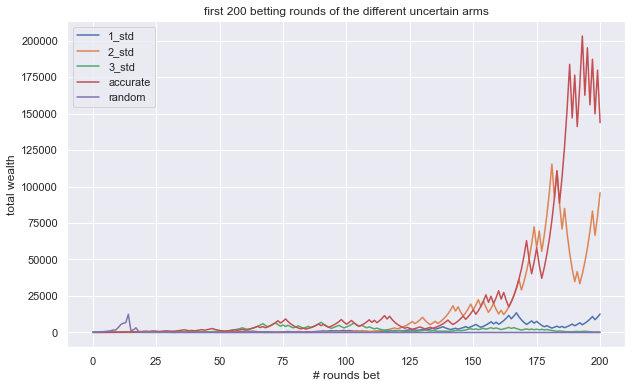

In [5]:
out.loc[0:200].plot(kind='line',title='first 200 betting rounds of the different uncertain arms',xlabel='# rounds bet',ylabel='total wealth',figsize=(10,6))

<AxesSubplot:title={'center':'cumulative wealth of different uncertain arms'}, xlabel='# rounds bet', ylabel='total wealth'>

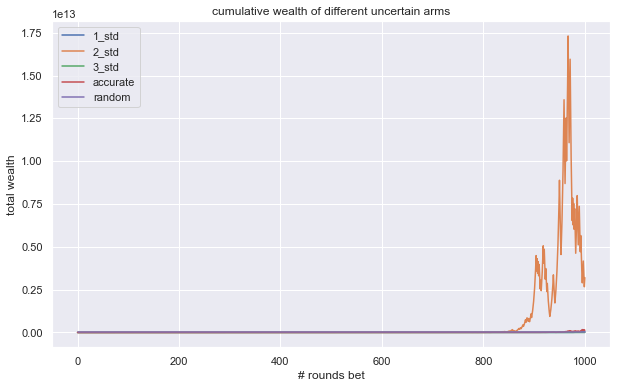

In [6]:
out.plot(kind='line',title='cumulative wealth of different uncertain arms',xlabel='# rounds bet',ylabel='total wealth',figsize=(10,6))

In [7]:
(out.iloc[-1] / out.iloc[0] - 1)

1_std       5.555747e+08
2_std       3.203723e+10
3_std       1.903113e+06
accurate    1.250043e+09
random     -1.000000e+00
dtype: float64

A single run of 1,000 betting rounds is shown above. The important output is the cumulative wealth of the arms relative to each other considering the change is sigma and uncertainty. (basically how wide the distributions are) Note, the meta models shown later just run 'n' number of the model shown above and quantify the ranks of the arms based on cumulative wealth generation relative to each other. 

The calculation for cumulative return is also shown above, the random model returns -100%. 

In [8]:
dists = pd.DataFrame({'{}_std'.format(s) : np.random.normal(60,s,1000) for s in [1,2,3]})

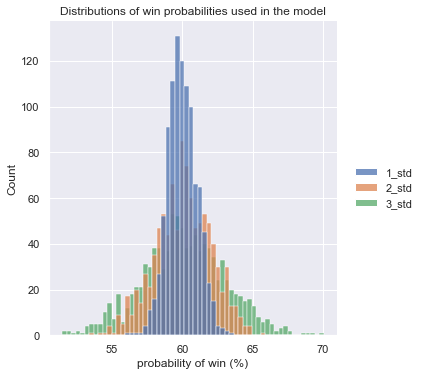

In [9]:
# plt.suptitle('Distributions of win probabilities used in the model')
ax = sns.displot(dists).set(title='Distributions of win probabilities used in the model',xlabel='probability of win (%)')
# plt.ylabel('probability of win (%)')

The distribution of win probability under the different sigmas are shown above. 

In [10]:
xx = metaSims(n=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.44it/s]


[Text(0.5, 1.0, 'bar plot of mean rank of cumulative return from 1,000 samples'),
 Text(0, 0.5, 'mean rank')]

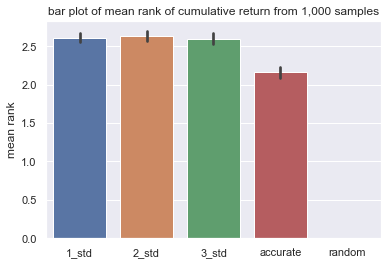

In [11]:
# plt.suptitle('Mean rank of each distribution model out of 1,000 samples')
sns.barplot(data=xx).set(title='bar plot of mean rank of cumulative return from 1,000 samples',ylabel='mean rank')

The bar plot above shows that the amount of uncertainty associated with the underlying process does not seem to be related at all to the amount of total wealth generated. The arms that are 'uncertain' all perform about the same in terms of mean rank of cumulative return. The random arm is always the lowest performing. The uncertain arms actually beat the completely accurate arm as well. 

These results seem to suggest that under the assumption of normallity in the distribution of expected outcomes, the mean can be used as an accurate estimator for the Kelly Bet on a discrete basis. 